# Описание проекта: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

Описание услуг
Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:
* Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
* Выделенная линия технической поддержки (`TechSupport`);
* Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
* Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).
Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

## Описание данных


Данные состоят из нескольких файлов, полученных из разных источников:
* `contract_new.csv` — информация о договоре;
* `personal_new.csv` — персональные данные клиента;
* `internet_new.csv` — информация об интернет-услугах;
* `phone_new.csv` — информация об услугах телефонии.


### Файл contract_new.csv

* `customerID` — идентификатор абонента;
* `BeginDate` — дата начала действия договора;
* `EndDate` — дата окончания действия договора;
* `Type` — тип оплаты: раз в год-два или ежемесячно;
* `PaperlessBilling` — электронный расчётный лист;
* `PaymentMethod` — тип платежа;
* `MonthlyCharges` — расходы за месяц;
* `TotalCharges` — общие расходы абонента.

### Файл personal_new.csv

* `customerID` — идентификатор пользователя;
* `gender` — пол;
* `SeniorCitizen` — является ли абонент пенсионером;
* `Partner` — есть ли у абонента супруг или супруга;
* `Dependents` — есть ли у абонента дети.

### Файл internet_new.csv

* `customerID` — идентификатор пользователя;
* `InternetService` — тип подключения;
* `OnlineSecurity` — блокировка опасных сайтов;
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
* `DeviceProtection` — антивирус;
* `TechSupport` — выделенная линия технической поддержки;
* `StreamingTV` — стриминговое телевидение;
* `StreamingMovies` — каталог фильмов.

### Файл phone_new.csv

* `customerID` — идентификатор пользователя;
* `MultipleLines` — подключение телефона к нескольким линиям одновременно.
    
    
Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## Импорты модулей и общие функции

In [1]:
!pip install -U scikit-learn -q
!pip install phik -q

In [2]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

### Функции для раздела загрузки

In [87]:
def view_and_get_data(path, sep=None, decimal=','):
    """
    Открывает файл, выводит первые 10 строк,
    основную информцию о дата фрейме и возвращает датафрейм.
    Принимает разделить в csv файле и разделитель десятичных чисел(по умолчанию запятая).
    """
    try:
        # Пробуем открыть файл локально, если нет, то через сервер яндекса.
        data = pd.read_csv(path, sep=sep, decimal=decimal, engine='python')
    except Exception:
        print('Локальный файл не найден. Пробую открыть серверную версию файла.')
        data = pd.read_csv(f'нет ссылкам{path}', sep=sep, decimal=decimal)
        
    display(data.head(10))
    print('\n', '    ', '-'*100, '\n')
    data.info()
    print('\n', '    ', '-'*100, '\n')
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    return data


def hist_and_box_numeric(data):
    """
    Принимает датафрейм для построения гистрограм и боксплотов для
    числовых столбцев.
    """
    columns = data.select_dtypes(exclude=['object']).columns.to_list()
    for_axis = list(zip(columns, range(0, len(columns)*2, 2)))
    fig, axes = plt.subplots(nrows=len(columns)*2, ncols=1, figsize=(8, 15))
    
    for name, number in for_axis:
        data[name].plot(
            ax=axes[number], kind='hist', bins=200, ylabel=name, rot=0);
        axes[number].set_title(f'Гистограмма {name}')
        axes[number].set_ylabel('Количество')
        axes[number].set_xlabel('Значения признака')
        data[name].plot(
            ax=axes[number+1], kind='box', ylabel='Разброс показателя', rot=0, vert=False);
        axes[number+1].set_title(f'Ящик с усами {name}')
    fig.tight_layout()    

    
def hist_and_box_obj(data):
    """
    Принимает датафрейм для построения гистрограм и боксплотов для
    категориальных столбцев.
    """
    columns = data.select_dtypes(include=['object']).columns

    if len(columns) > 1:
        columns = columns.to_list()
        fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 15))
        for number in range(len(columns)):
            data[columns[number]].value_counts(normalize=True).plot(
                ax=axes[number], kind='bar', xlabel=columns[number], ylabel='Доля', rot=15);
            axes[number].set_title(f'Диаграмма {columns[number]}')
        fig.tight_layout()
    else:
        columns = columns.to_list()
        data[columns[0]].value_counts(normalize=True).plot(
            kind='bar', xlabel=columns[0], ylabel='Доля', rot=15, title=f'Диаграмма {columns[0]}');

def short_describe(data):
    """Сокращенная версия метдоа describe для упроженного анализа признаков."""
    data = data.describe()
    display(data[data.index.isin(['std', '50%', 'min', 'max'])].T)

def columns_in_snake_case(df):
    """Принимает фрейм, переводит его колонки в snake_case при работе с camelCase."""
    df.columns = (df.columns
                    .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                    .str.lower()
                 )
    df.head()

### Функции для обработки или создания признаков

In [4]:
def create_target(row):
    """
    Получает строку фрейма и определеяет целевую переменную по условию:
        Если значение в end_date равно No, то в столбце target будет 0(клиент не уйдёт);
        Если значение в end_date не равно No, то в столбце target будет 1(клиент может уйти).
    """
    if row['end_date'] == 'No':
        return 0
    return 1

def days_before_payment(row):
    """
    Вычисляет количество дней до следующего платежа. По условиям задачи
    оплата может быть ежемесячно, раз в год, раз в два года.
    
    """
    if row['type_data'] == 'Month-to-month':
        return row['client_days'] % 30
    elif row['type_data'] == 'One year':
        return row['client_days'] % 365
    return row['client_days'] % 730

### Функции исследовательского анализа

In [5]:
def research_numeric_data(data, value):
    """Выводим описание столбца числового типа, гистограмму с этим столбцом."""
    print('Описание данных:')
    display(data[value].describe().T)
    print('\n', '    ', '-'*100, '\n')
    print('Уникальные значения(10 наиболее частых):')
    display(data[value].value_counts(ascending=False).head(10))
    print('\n', '    ', '-'*100, '\n')
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))

    data[value].plot(
        ax=axes[0], kind="hist", rot=0);
    axes[0].set_title(f"Гистограмма {value}")
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(f'Значения признака {value}')
    data[value].plot(
        ax=axes[1], kind="box", xlabel=value, rot=0);
    axes[1].set_title(f'Ящик с усами {value}')
    fig.tight_layout()

    
def research_object_data(data, value):
    """Выводим описание столбца категориального типа, график с этим столбцом."""
    print('Уникальные значения:')
    display(data[value].value_counts(ascending=False))
    print('\n', '    ', '-'*100, '\n')
    print(f'Линейчатый график для показателя: {value}')
    data[value].value_counts().plot(
        kind="bar",
        xlabel=value,
        ylabel='Количество',
        rot=45);

def scatter_plot(data, x, y, objects):
    """Строит диаграммы рассеяния по переданным признакам в зависимости от списка категориальных."""
    row = 0
    column = 0
    fig, axes = plt.subplots(nrows=(len(objects) % 3), ncols=3, figsize=(20, 15))
    for obj in objects:
        sns.scatterplot(data=data, x=x, y=y, hue=obj, palette="husl", ax=axes[row, column])
        column += 1
        if column == 3:
            column = 0
            row += 1
    plt.show()

def research_numeric_data_with_target(data, value, target):
    """
    Распределение числового признака в зависимости от целевого.
    Наложенные диаграммы и два боксплота.
    """
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))
    
    unique_target = data[target].unique()
    
    data[data[target] == unique_target[0]][value].plot(
        ax=axes[0], kind="hist", rot=0, color="g", label=unique_target[0], alpha=0.5)
    data[data[target] == unique_target[1]][value].plot(
        ax=axes[0], kind="hist", rot=0, color="r", label=unique_target[1], alpha=0.5)
    axes[0].set_title('Гистограммы с целевым признаком')
    axes[0].set_ylabel('Количество')
    axes[0].legend()
    axes[0].set_xlabel(f'Значения признака {value}')
    
    data[data[target] == unique_target[0]][value].plot(
        ax=axes[1], kind="box", xlabel=value, rot=0);
    axes[1].set_title(f'Боксплот с целевым признаком {unique_target[0]}')
    
    data[data[target] == unique_target[1]][value].plot(
        ax=axes[2], kind="box", xlabel=value, rot=0);
    axes[2].set_title(f'Боксплот с целевым признаком {unique_target[1]}')
    fig.tight_layout()
    
    print('Корреляция Phik:', np.round(phik_overview.loc[value]['target'], 2))
    print('\n', '    ', '-'*100, '\n')

def research_object_data_with_target(data, value, target):
    """
    Распределение категориального признака в зависимости от целевого.
    Две диаграммы.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
    
    unique_target = data[target].unique()
    
    data[data[target] == unique_target[1]][value].value_counts().plot(
        ax=axes[0],
        kind="bar",
        xlabel=value,
        ylabel='Количество',
        rot=45, color="r");
    axes[0].set_title(f'График для показателя: {value} c признаком {unique_target[1]}')

    data[data[target] == unique_target[0]][value].value_counts().plot(
        ax=axes[1],
        kind="bar",
        xlabel=value,
        ylabel='Количество',
        rot=45, color="g");
    axes[1].set_title(f'График для показателя: {value} c признаком {unique_target[0]}')
    fig.tight_layout()
    
    print('Корреляция Phik:', np.round(phik_overview.loc[value]['target'], 2))
    print('\n', '    ', '-'*100, '\n')

### Константы

In [6]:
RANDOM_STATE = 30624
TEST_SIZE = 0.25

## Загрузка данных и изучение общей информации

###  Файл contract_new.csv

In [7]:
df_contract = view_and_get_data('/datasets/contract_new.csv')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35



      ---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

      ---------------------------------------------------------------------------------------------------- 

Количество явных дубликатов: 0


Во фрейме 7043 строки, 8 столбцов(столбец `MonthlyCharges` имеет тип числа с плавающей точкой, остальные текстовые). Пропусков нет. Стиль именования столбцов не соответсвует snake_case. Сразу же исправим это.

#### Приводим колонки к стилю snake_case

In [8]:
columns_in_snake_case(df_contract)

df_contract.rename(columns={
    'type': 'type_data',
    }, inplace = True)
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type_data          7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


#### Преобразование типов

По предварительному анализу датафрейма возникают вопросы с типами для столбцов с датами, а так же с общими расходами абонента на связь.


In [9]:
df_contract['begin_date'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

In [10]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')

In [11]:
df_contract['total_charges'].sort_values()

3331          
4380          
6670          
488           
3826          
         ...  
2880    997.78
3267    998.89
6023     999.6
1700     999.6
1625     999.9
Name: total_charges, Length: 7043, dtype: object

В данных присутствуют пробелы или пустые строки без значений. Скорее всего это новые контракты, где пользователи еще не вносили оплату, поэтому можем заменить пропуски на нули.

In [12]:
df_contract['total_charges'] = df_contract[['total_charges']].replace(' ', 0).astype('float64')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type_data          7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Где это можно было, типы были преобразованы. Теперь фрейм выглядит более уместно в разрезе типов данных.

#### Гистограммы и боксплоты

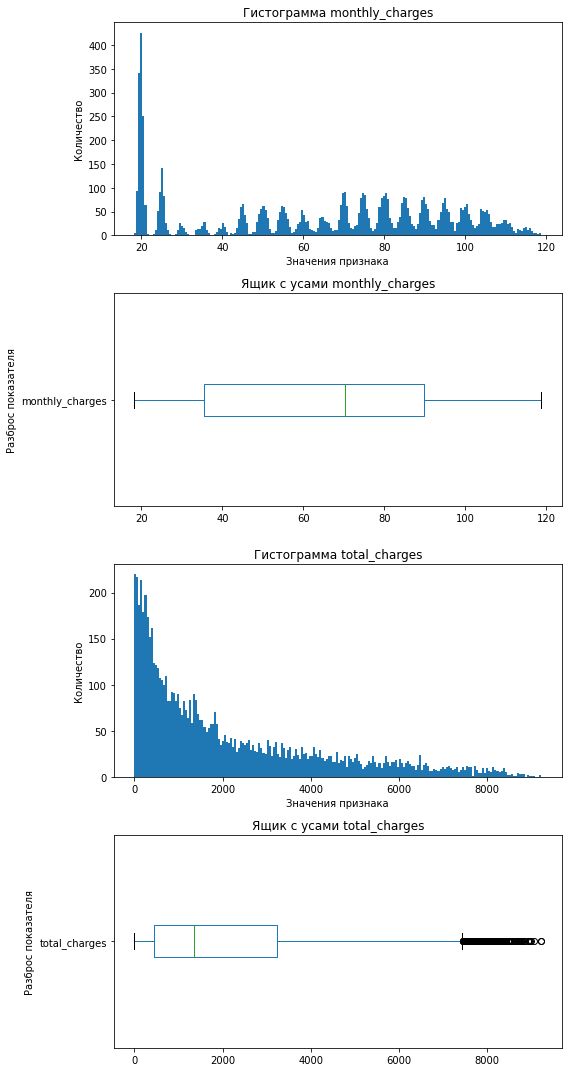

In [13]:
hist_and_box_numeric(df_contract.drop(['customer_id', 'begin_date'], axis=1))

In [14]:
short_describe(df_contract)

,std,min,50%,max
monthly_charges,30.090047,18.25,70.35,118.75
total_charges,2112.742814,0.00,1343.35,9221.38


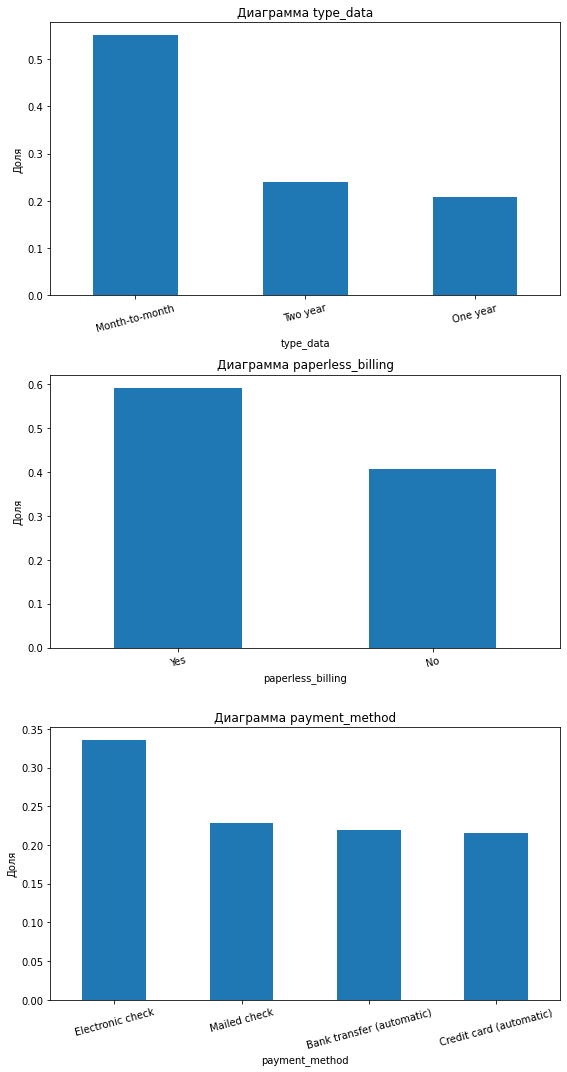

In [15]:
hist_and_box_obj(df_contract.drop(['customer_id', 'begin_date', 'end_date'], axis=1))

**Вывод:**    
* Предварительно уже заметна разница в стоимости, которую платят абоненты. С вреднем в месяц порядка 70, если стоимость связи превышает это значение, то можно предположить, что клиент может быть потерян;
* Общие расходы направляют в ту же сторону;
* Порядка 55% клиентов предпочитают ежемесячную оплату, либо компания предпочитает такой способ оплаты;
* Почти 60% клиентов предпочитают электронный расчетный лист;
* По типу платежа преимущество за электронным чеком, три остальных способа находятся примерно в равных пропорциях.

###  Файл personal_new.csv

In [16]:
df_personal = view_and_get_data('/datasets/personal_new.csv')

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes



      ---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

      ---------------------------------------------------------------------------------------------------- 

Количество явных дубликатов: 0


В данных порядка 7043 строк, один целочисленный тип, хотя он относится к категории в целом(пенсионер или нет) и 4 текстовых стобца.

#### Приводим колонки к стилю snake_case

In [17]:
# Можно было бы привести столбцы к нижнему регистру предварительно, но явное лучше неявного.
columns_in_snake_case(df_personal)

#df_personal.rename(columns={
##    'customerID': 'customer_id',
#    'SeniorCitizen': 'senior_citizen',
#    'Partner': 'partner',
#    'Dependents': 'dependents'
#    }, inplace = True)
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


#### Гистограммы

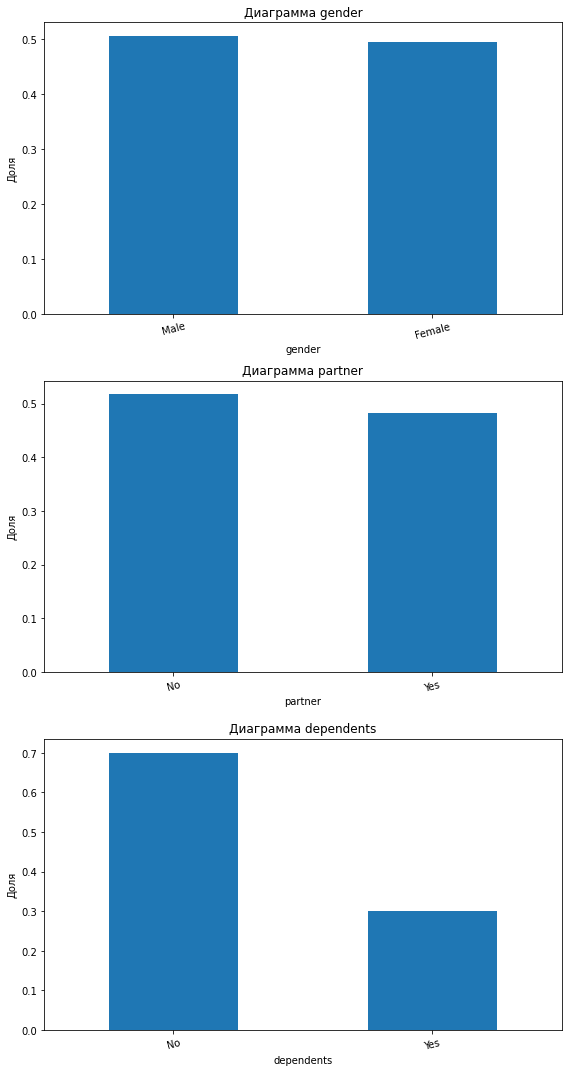

In [18]:
hist_and_box_obj(df_personal.drop(['customer_id'], axis=1))

In [19]:
pd.DataFrame(df_personal['senior_citizen'].value_counts(normalize=True))

,senior_citizen
0,0.837853
1,0.162147


**Вывод:**
* Пол абонента распределен примерно 50 на 50 мужчин и женщин;
* Наличие супруга(и) у порядка 50%;
* Только у 30% есть дети;
* Примерно 16% абонентов являются пенсионерами.

###  Файл internet_new.csv

In [20]:
df_internet = view_and_get_data('/datasets/internet_new.csv')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No



      ---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

      ---------------------------------------------------------------------------------------------------- 

Количество явных дубликатов: 0


В фрейме порядка 5517 строк, 8 столбцов и они все строкового типа. В данном фрейме строк меньше чем в предыдущем, скорее всего не у всех абонентов подключен интернет, либо не всем он нужен.

#### Приводим колонки к стилю snake_case

In [21]:
columns_in_snake_case(df_internet)

#df_internet.rename(columns={
#    'customerID': 'customer_id',
#    'InternetService': 'internet_service',
##    'OnlineBackup': 'online_backup',
#    'DeviceProtection': 'device_protection',
##    'TechSupport': 'tech_support',
#    'StreamingTV': 'streaming_tv',
#    'StreamingMovies': 'streaming_movies',
#    }, inplace = True)
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


#### Гистограммы

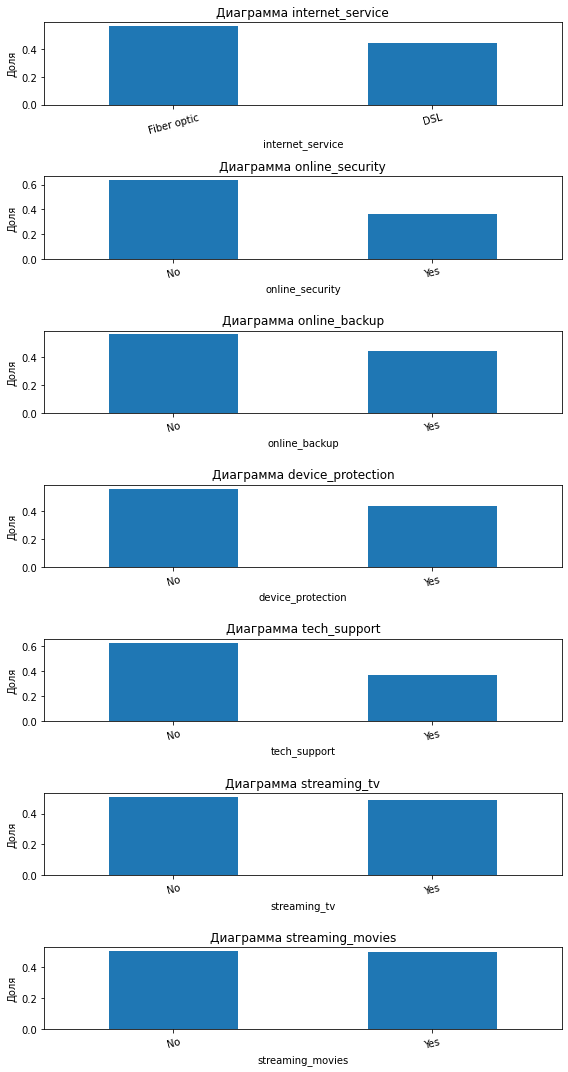

In [22]:
hist_and_box_obj(df_internet.drop(['customer_id'], axis=1))

**Вывод:**
* Наиболее используемый тип подключеня оптика, его используют в 60% случаев;
* Блокировка опасных сайтов включена у 60% абонентов;
* Резервным копированием пользуется только 40% абонентов;
* Антивирусом пользуется около 40% абонентов;
* Выделенная линия технической поддержки у 35% абонентов;
* Стриминговое телевидение и каталог фильмов есть у порядка 50% абонентов.

###  Файл phone_new.csv

In [23]:
df_phone = view_and_get_data('/datasets/phone_new.csv')

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes



      ---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

      ---------------------------------------------------------------------------------------------------- 

Количество явных дубликатов: 0


В данном фрейме уже 6361 строка, так же меньше чем в первом. Значит, есть и клиенты, что не пользуются интернетом,но пользуются телефоном. Оба столбца строчного типа.

#### Приводим колонки к стилю snake_case

In [24]:
columns_in_snake_case(df_phone)

#df_phone.rename(columns={
#    'customerID': 'customer_id',
#    'MultipleLines': 'multiple_lines',
#    }, inplace = True)
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


#### Гистограммы

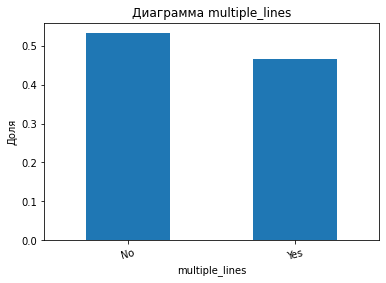

In [25]:
hist_and_box_obj(df_phone.drop(['customer_id'], axis=1))

**Вывод:**
Примерно у 55% абоненов нет подключения телефона к нескольким линиям одновременно.

### Вывод

* Были рассмотрены 4 фрейма данных;
* Ни в одном фрейме не обнаружено пропусков или явных дубликатов;
* Предварительно уже заметна разница в стоимости, которую платят абоненты. С вреднем в месяц порядка 70, если стоимость связи превышает это значение, то можно предположить, что клиент может быть потерян;
* Общие расходы направляют в ту же сторону;
* Порядка 55% клиентов предпочитают ежемесячную оплату, либо компания предпочитает такой способ оплаты;
* Почти 60% клиентов предпочитают электронный расчетный лист;
* По типу платежа преимущество за электронным чеком, три остальных способа находятся примерно в равных пропорциях;
* Пол абонента распределен примерно 50 на 50 мужчин и женщин;
* Наличие супруга(и) у порядка 50%;
* Только у 30% есть дети;
* Примерно 16% абонентов являются пенсионерами;
* Наиболее используемый тип подключеня оптика, его используют в 60% случаев;
* Блокировка опасных сайтов включена у 60% абонентов;
* Резервным копированием пользуется только 40% абонентов;
* Антивирусом пользуется около 40% абонентов;
* Выделенная линия технической поддержки у 35% абонентов;
* Стриминговое телевидение и каталог фильмов есть у порядка 50% абонентов.
* Примерно у 55% абоненов нет подключения телефона к нескольким линиям одновременно.

## Объединение данных

Объединим дата фреймы. Ранее мы уже заметили предварительные возможные пропуски в данных и возможную причину этого. После объединения проверим появились ли пропуски.

In [26]:
df = df_contract.copy()
df = (
    df.merge(df_personal, on='customer_id', how='outer')
      .merge(df_internet, on='customer_id', how='outer')
      .merge(df_phone, on='customer_id', how='outer')
)
df.head()

,customer_id,begin_date,end_date,type_data,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type_data          7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

Как и предполагалось пропуски появились. Выведем количество пропусков во фрейме.

In [28]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type_data               0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Пропуски заполним на следующем этапе, как и оставшую предобработку.   
**Вывод:**
Для объединения использовали метод `merge`. В данных появились пропуски, которые вызваны скорее всего тем, что не у всех пользователей использующих интернет подключен телефон и наоборот - использующие телефон не обязательно пользуются интернетом.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Заполним пропуски. В план доработок проекта добавлю `SimpleImputer`. Нужно время подумать над эффективностью его применения здесь, в виду ограниченности времени на диплом не получистя хорошенько всё обдумать, прикинуть разные случаи и т.п.. Он может заполнить пропуски как для числовых колонок, так и для категориальных. Это может быть более эффективным для будущих проектов. Хм, однако тут мы предполагаем, что пропуски появились из-за отсутствия у некоторых клиентов услуг интернета и телефонии у других. Тогда бы приходилось формировать несколько пайплайнов, чтобы заполнить их более понятными значениями для таких деталей, либо выбрать единую стратегию для замены всех пропусков, но так мы теряем "понятность". На текущий момент заполним пропуски заглушками, но после сдачи или если останется время, то обязательно проверить в этом месте использование пайплайнов с импутером.

Для пропусков в данных по интернету заполним заглушкой - `INC`(internet not connected), для пропусков по телефонии - `PNC`(phone not connected).

In [29]:
df[df_internet.columns] = df[df_internet.columns].fillna('INC')
df[df_phone.columns] = df[df_phone.columns].fillna('PNC')
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type_data            0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64


<div class="alert alert-block alert-warning"; style="border-left: 6px solid orange">
<b>Рекомендация ⚠️</b>
       
Молодец, что рассматриваешь разные варианты по пропускам и природе их появления! На самом деле в нашем случае все очень просто и лучшим решением было бы использовать уже существующую категорию 'No' для всех пропусков в объединенном датасете, но твой вариант тоже рабочий, поэтому продолжаем)
    
</div>


### Целевой признак

Нашелью целью является предсказать откажется ли клиент от услуг связи, то целевым признаком является `end_date`, в котором указана дата окончания договора. Ранее мы видили, что в стобце есть значение `No`.
* Если значение в end_date равно `No`, то в столбце `target` будет 0(клиент не уйдёт);
* Если значение в end_date не равно `No`, то в столбце `target` будет 1(клиент может уйти).

Выделяем целевой признак в отдельный столбец, так как столбцы с типом даты приводят к утечкам.

In [30]:
df['target'] = df.apply(create_target, axis=1)
df[['end_date','target']].sample(10)

,end_date,target
5420,2017-01-01,1
6511,No,0
4691,2016-08-01,1
3645,No,0
6960,No,0
138,No,0
277,No,0
3416,No,0
6513,No,0
6614,No,0


Отображение случайных 10 значений из фрейма позволяет нам увидеть, что преобразование прошло успешно. Визуализируем полученный результат.

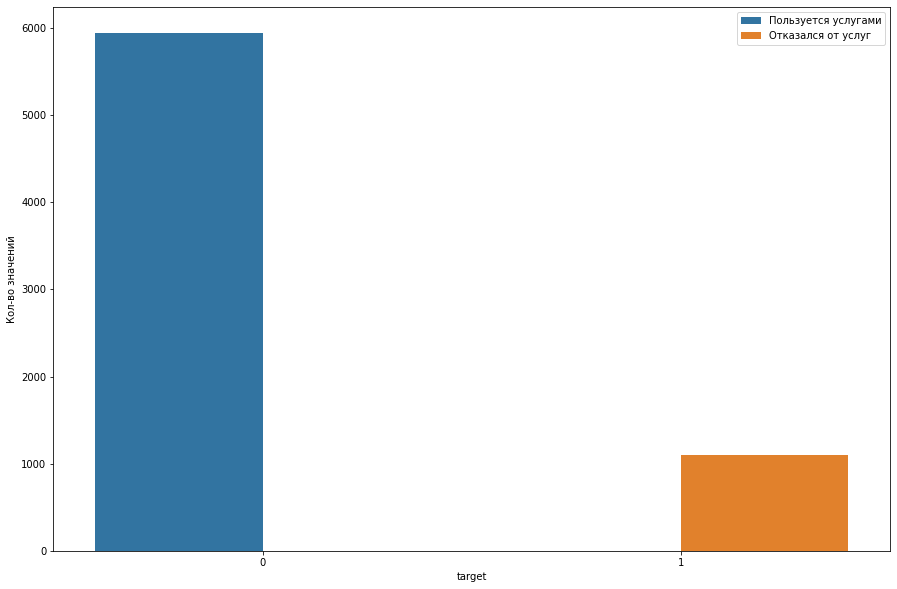

In [31]:
plt.figure(figsize = (15,10))
sns.countplot(data=df, x='target', hue='target').set(ylabel='Кол-во значений');
plt.legend(['Пользуется услугами', 'Отказался от услуг']);

In [32]:
df['target'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: target, dtype: float64

По количеству и доле значений целдевого признака можно увидеть, что возможно плнируют отказаться от услуг порядка 15%, что в целом довольно большое количество.

### Работа с признаками

Заменим значение закодированного признака является абонент пенсинонером или нет, чтобы далее было удобнее и логичнее работать с признаками.

In [33]:
df.loc[df['senior_citizen'] == 0, 'senior_citizen'] = 'No'
df.loc[df['senior_citizen'] == 1, 'senior_citizen'] = 'Yes'
df['senior_citizen'].unique()

array(['No', 'Yes'], dtype=object)

Создадим новый признак `client_days`, означающий сколько дней клиент пользовался услугами.

In [34]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')
df['client_days'] = (df['end_date'] - df['begin_date']).dt.days
df[['begin_date', 'end_date', 'client_days']].head()

,begin_date,end_date,client_days
0,2020-01-01,2020-02-01,31
1,2017-04-01,2020-02-01,1036
2,2019-10-01,2020-02-01,123
3,2016-05-01,2020-02-01,1371
4,2019-09-01,2020-02-01,153


Создадим еще один признак `dbp`(days before payment - дней до оплаты за следующий период).

In [35]:
df['dbp'] = df.apply(days_before_payment, axis=1)
df[['type_data', 'client_days', 'dbp']].head(10)

,type_data,client_days,dbp
0,Month-to-month,31,1
1,One year,1036,306
2,Month-to-month,123,3
3,One year,1371,276
4,Month-to-month,153,3
5,Month-to-month,337,7
6,Month-to-month,671,11
7,Month-to-month,306,6
8,Month-to-month,945,15
9,One year,882,152


Удалим предварительно ненужные нам признаки для машинного обучения, которые только запутают модель.

In [36]:
del df['begin_date']
del df['end_date'] 
del df['customer_id']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type_data          7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

По итогу мы добавили несколько новых признаков сколько клиент пользовался нашими услугами с даты заключения договора и сколько осталось дней до следующего платежа. Удалили признаки, что могут создавать утечки и идентификатор клиента, который не нужен модели.

### Матрица корреляции

Построим матрицу корреляции.

In [37]:
phik_overview = df.phik_matrix(interval_cols=['monthly_charges', 'total_charges',
                                              'client_days', 'dbp'])
phik_overview.round(2);

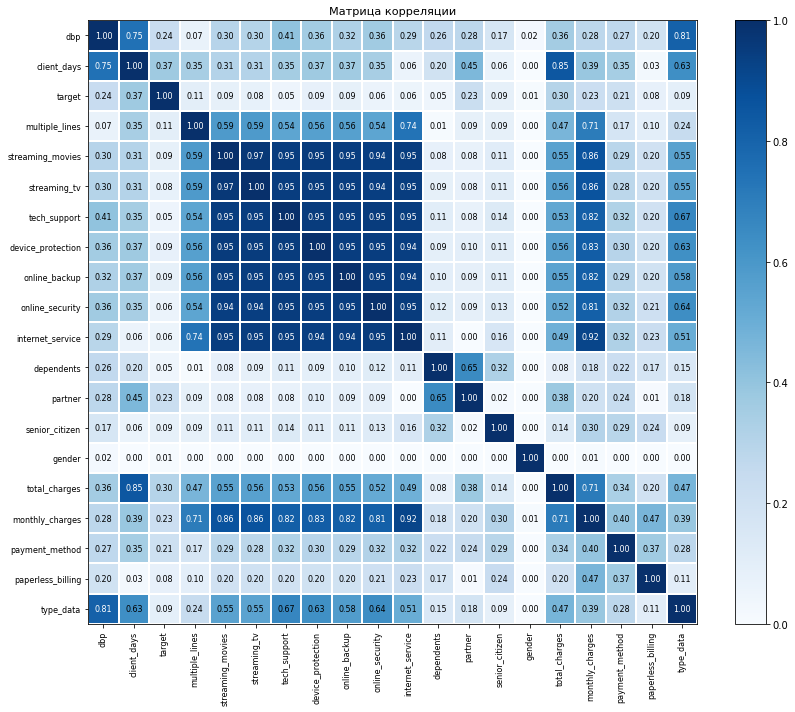

In [38]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', 
                        title='Матрица корреляции', 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

Избавимся от мультиколлинеарности и признаков с очень низкой корреляцией с целевой переменной:
* streaming_movies
* streaming_tv
* tech_support
* device_protection
* online_backup
* online_security
* internet_service
* dependents
* gender
* paperless_billing
* type_data

In [39]:
df = df.drop(['streaming_movies', 'streaming_tv', 'tech_support',
             'device_protection', 'online_backup', 'online_security', 'internet_service',
              'dependents', 'gender', 'paperless_billing', 'type_data'],
           axis=1)

Пострим матрицу корреляции еще раз.

In [40]:
phik_overview = df.phik_matrix(interval_cols=['monthly_charges', 'total_charges',
                                              'client_days', 'dbp'])
phik_overview.round(2);

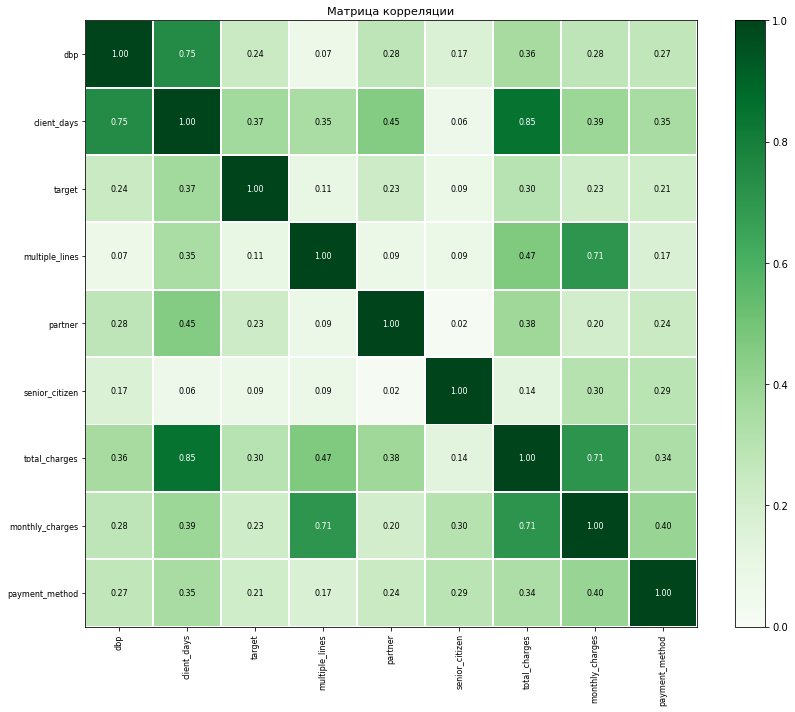

In [41]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', 
                        title='Матрица корреляции', 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

### Анализ отдельных признаков с целевым

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   payment_method   7043 non-null   object 
 1   monthly_charges  7043 non-null   float64
 2   total_charges    7043 non-null   float64
 3   senior_citizen   7043 non-null   object 
 4   partner          7043 non-null   object 
 5   multiple_lines   7043 non-null   object 
 6   target           7043 non-null   int64  
 7   client_days      7043 non-null   int64  
 8   dbp              7043 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 808.3+ KB


Для удобства анализа создадим дополнительный фрейм и добавим в него более явное наименование признака.

In [43]:
df_analisys = df.copy()
df_analisys['target_text'] = df_analisys['target'].apply(lambda x: 'Уйдёт' if x == 1 else 'Останется')
df_analisys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   payment_method   7043 non-null   object 
 1   monthly_charges  7043 non-null   float64
 2   total_charges    7043 non-null   float64
 3   senior_citizen   7043 non-null   object 
 4   partner          7043 non-null   object 
 5   multiple_lines   7043 non-null   object 
 6   target           7043 non-null   int64  
 7   client_days      7043 non-null   int64  
 8   dbp              7043 non-null   int64  
 9   target_text      7043 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 863.3+ KB


#### payment_method

Уникальные значения:


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64


      ---------------------------------------------------------------------------------------------------- 

Линейчатый график для показателя: payment_method


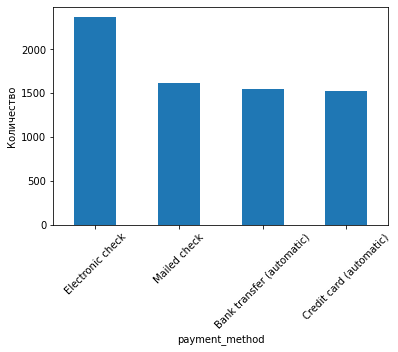

In [44]:
research_object_data(df_analisys, 'payment_method')

Корреляция Phik: 0.21

      ---------------------------------------------------------------------------------------------------- 



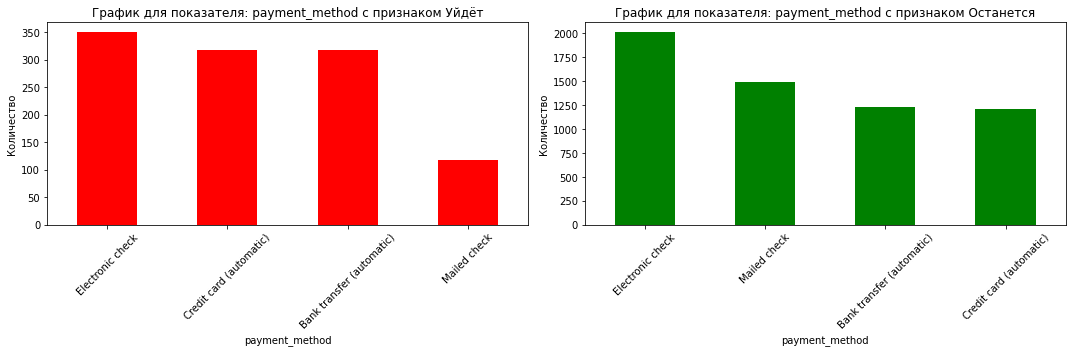

In [45]:
research_object_data_with_target(df_analisys, 'payment_method', 'target_text')

Люди, оплачивающие услуги с помощью электронного чека, кредитной карты или банковской карты уйдут в примерно одинаковой пропорции, в отличии от тех, кто оплачивает с помощью чека по почте - их примерно в три раза меньше. При этом останутся в большем количестве те, кто оплачивает электронным чеком, затем чеком на почту, и примерно в равной степени использующие банковские и кредитные карты.

#### monthly_charges 

Описание данных:


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64


      ---------------------------------------------------------------------------------------------------- 

Уникальные значения(10 наиболее частых):


20.05    61
19.85    45
19.90    44
19.95    44
19.65    43
19.70    43
20.00    43
19.55    40
20.15    40
19.75    39
Name: monthly_charges, dtype: int64


      ---------------------------------------------------------------------------------------------------- 



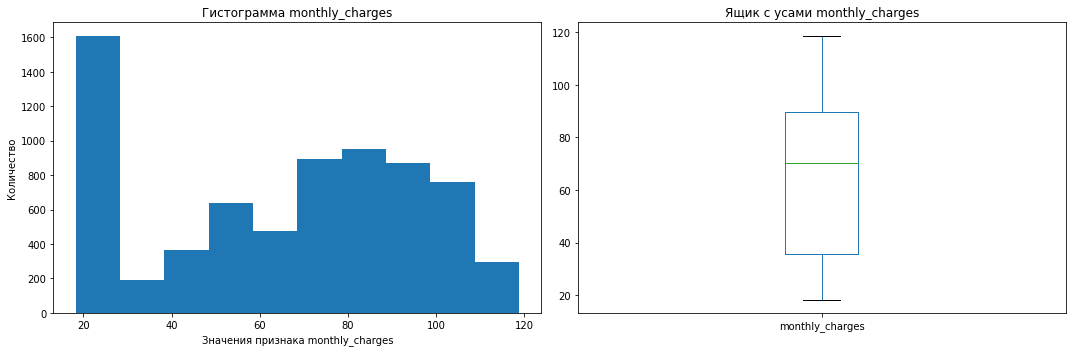

In [46]:
research_numeric_data(df_analisys, 'monthly_charges')

Корреляция Phik: 0.23

      ---------------------------------------------------------------------------------------------------- 



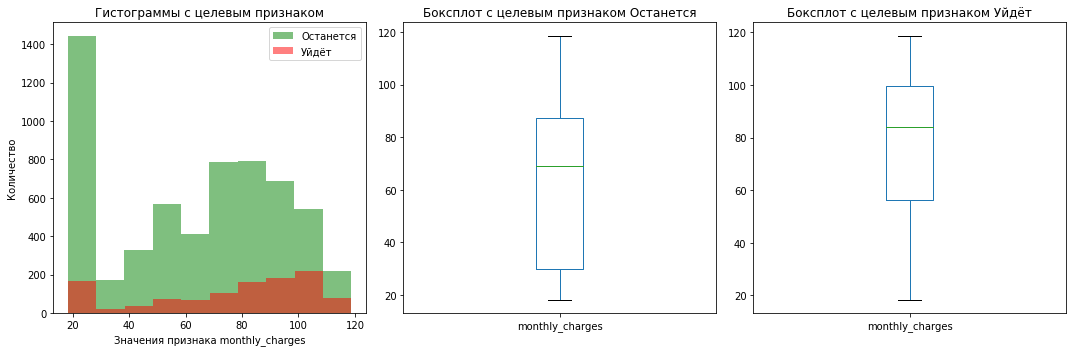

In [47]:
research_numeric_data_with_target(df_analisys, 'monthly_charges', 'target_text')

На основании данных, можно сделать вывод, что остаются в большей степени клиенты, чьи ежемесячные расходы составляют около 75 и ниже. Уйдут с большей вероятностью те, чьи ежемесячные расходы превысят 80. Однако на гистограмме так же можно заметить, что доля тех, кто платит около 20 в месяц уходят в таком же количестве как и те, кто платит около 100-110 ежемесячно. Возможно, это старые клиенты, которые отказываются от услуг оператора по каким-то своим причинам(не устроило качество). Возможно, это клиенты которые платили более 100 ежемесячно, а потом им на месяц сделали скидку или просто сделали скидку до 30 за ежемесячный платеж. Хорошо бы выяснить причину такой разницы в ежемесячном платеже.

#### total_charges

Описание данных:


count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64


      ---------------------------------------------------------------------------------------------------- 

Уникальные значения(10 наиболее частых):


0.00       11
20.45       6
101.00      5
255.00      4
40.10       4
21.53       4
732.60      4
1007.50     4
19.65       4
1192.80     3
Name: total_charges, dtype: int64


      ---------------------------------------------------------------------------------------------------- 



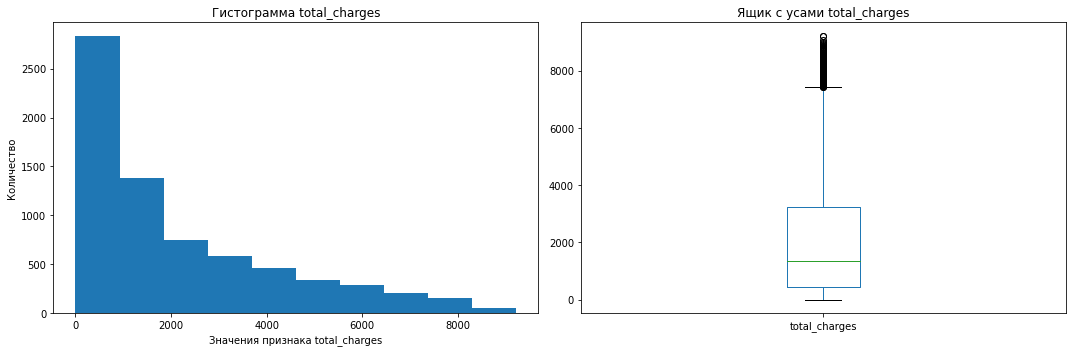

In [48]:
research_numeric_data(df_analisys, 'total_charges')

Корреляция Phik: 0.3

      ---------------------------------------------------------------------------------------------------- 



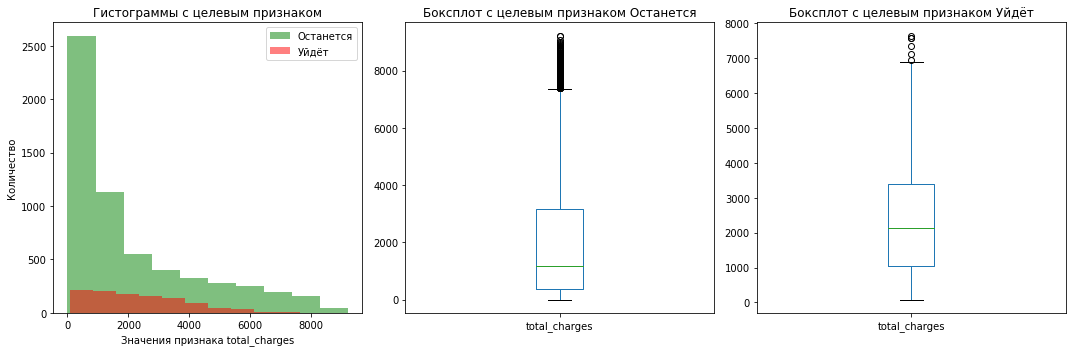

In [49]:
research_numeric_data_with_target(df_analisys, 'total_charges', 'target_text')

В данных заметно, что у некоторых клиентов общие расходы равны 0, что говорит о том, что это еще новые клиенты. График на первый взгляд может ввести в заблуждение из-за снижения количества тех кто уходит с увеличением расходов. Можно предположить, что в большей степени люди уходят практически сразу, и не пользуются долго услугами оператора. В большей степени останутся те, чьи общие расходы не превышают примерно 1600. Если общие расходы клиента превышают 2000 за всё время, то есть вероятность что он уйдет. Отсюда появляются несколько случаев - новые клиенты с низкими расходами скорее останутся чем уйдут, а старые клиенты без каких-либо бонусных программ будут уходить. При этом часть новых клиентов даже при низких расходах уходят. Проанализировать что их отталкивает, может быть низкое качество, малый спектр услуг.

#### senior_citizen

Уникальные значения:


No     5901
Yes    1142
Name: senior_citizen, dtype: int64


      ---------------------------------------------------------------------------------------------------- 

Линейчатый график для показателя: senior_citizen


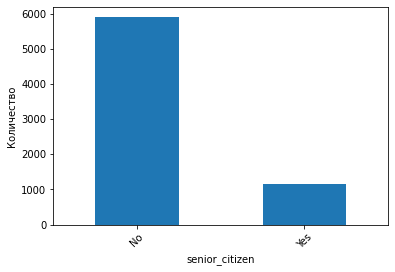

In [50]:
research_object_data(df_analisys, 'senior_citizen')

Корреляция Phik: 0.09

      ---------------------------------------------------------------------------------------------------- 



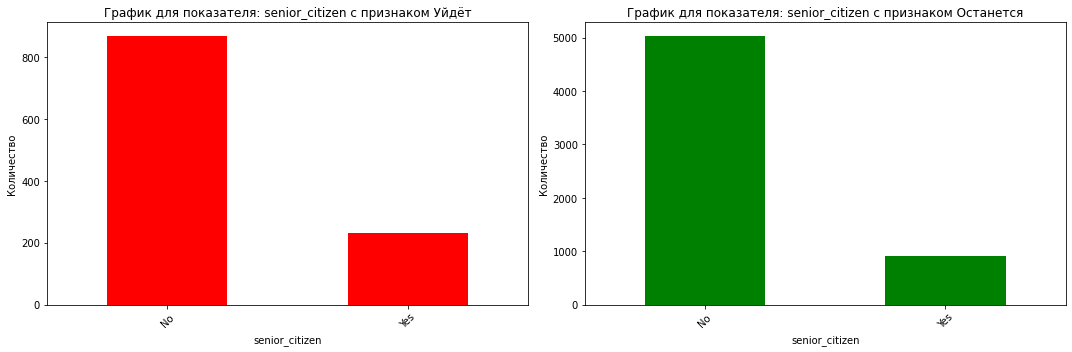

In [51]:
research_object_data_with_target(df_analisys, 'senior_citizen', 'target_text')

Касательно пенсионеров какой-то явной связи или выводов сделать нельзя. Единственное, чо бросается в глаза уходяшие клиенты пенсионеры в большем количестве уйдут чем останутся, относительно не пенсионеров. Возможен вариант того, что со временем стоимость услуг растет и это отталкивает эту группу населения. Либо оператор им навязчиво предлагает неактуальные услуги.

#### partner

Уникальные значения:


No     3641
Yes    3402
Name: partner, dtype: int64


      ---------------------------------------------------------------------------------------------------- 

Линейчатый график для показателя: partner


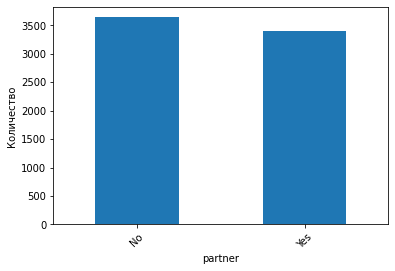

In [52]:
research_object_data(df_analisys, 'partner')

Корреляция Phik: 0.23

      ---------------------------------------------------------------------------------------------------- 



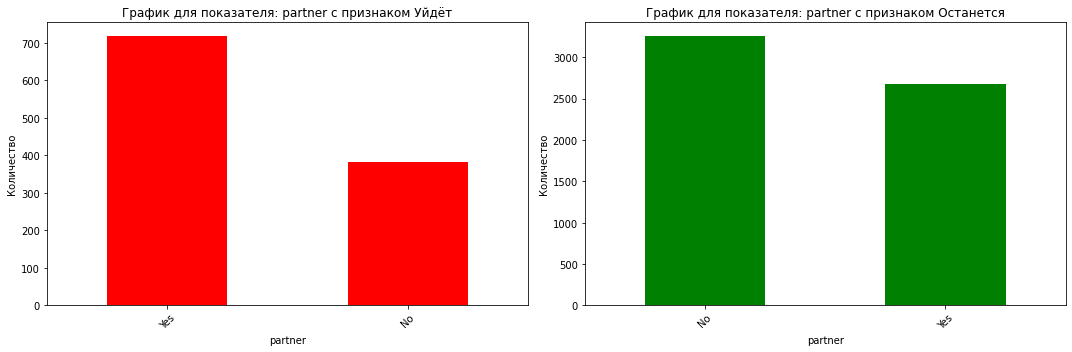

In [53]:
research_object_data_with_target(df_analisys, 'partner', 'target_text')

По части наличия супруги(а) с большей вероятность уходят те, у кого оный(ая) есть, что может объяснятся возрастающим количеством расходов, поскольку в данном случае вопрос в обеспечении семьи. Остаютя примерно в равной степени те, кто имеет вторую половинку и те, кто не имеет её.

#### multiple_lines

Уникальные значения:


No     3390
Yes    2971
PNC     682
Name: multiple_lines, dtype: int64


      ---------------------------------------------------------------------------------------------------- 

Линейчатый график для показателя: multiple_lines


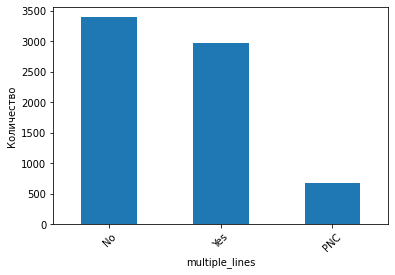

In [54]:
research_object_data(df_analisys, 'multiple_lines')

Корреляция Phik: 0.11

      ---------------------------------------------------------------------------------------------------- 



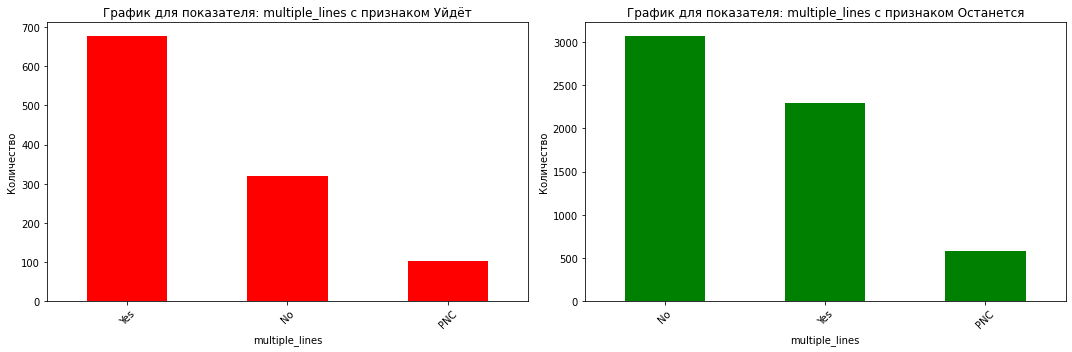

In [55]:
research_object_data_with_target(df_analisys, 'multiple_lines', 'target_text')

В большей степени уйдут те, у кого подключен телефон, останутся те, у кого он не подключен. Подкрепляя предшествующие данные можно предположить, что оператор повышает цены на телефонную связь и тем самым возрастные клиенты уходят, а так же и в целом клиенты, что пользуются телефонией. Проверить стоимость и качество этой услуги.

#### client_days

Описание данных:


count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: client_days, dtype: float64


      ---------------------------------------------------------------------------------------------------- 

Уникальные значения(10 наиболее частых):


2191    265
153     249
92      243
31      236
123     236
62      225
215     153
184     147
245     141
365     135
Name: client_days, dtype: int64


      ---------------------------------------------------------------------------------------------------- 



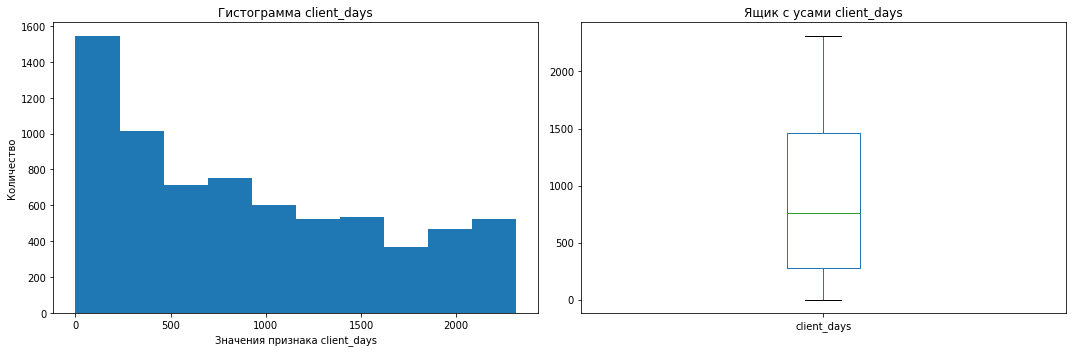

In [56]:
research_numeric_data(df_analisys, 'client_days')

Корреляция Phik: 0.37

      ---------------------------------------------------------------------------------------------------- 



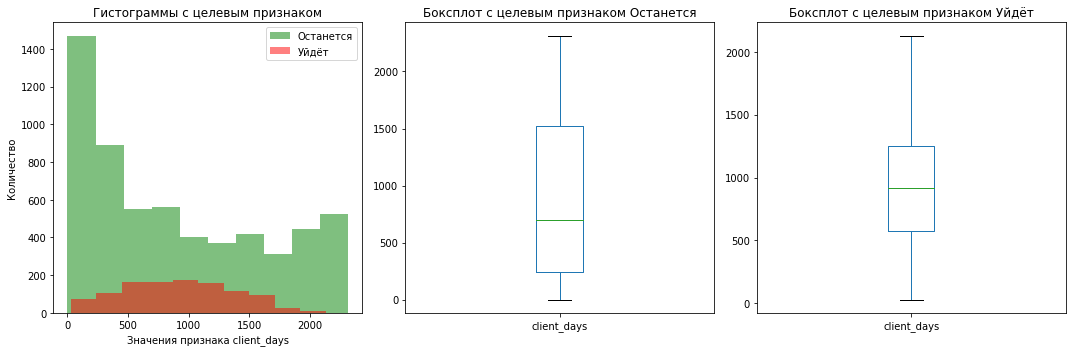

In [57]:
research_numeric_data_with_target(df_analisys, 'client_days', 'target_text')

В большей степени клиенты уходят на интервале примерно 900-1100 дней. Оператору стоит проверить стратегию на этот период - не улучшается качество, нет скидов или бонусов, обновление общей инфраструктуры. Вероятно, есть какая-то причина по которой с большей вероятностью клиенты уходят именно в этот период.

#### dbp

Описание данных:


count    7043.000000
mean      123.228454
std       191.818141
min         0.000000
25%         4.000000
50%        13.000000
75%       185.000000
max       703.000000
Name: dbp, dtype: float64


      ---------------------------------------------------------------------------------------------------- 

Уникальные значения(10 наиболее частых):


1     597
3     483
2     460
5     362
6     306
7     252
10    187
12    161
11    156
8     152
Name: dbp, dtype: int64


      ---------------------------------------------------------------------------------------------------- 



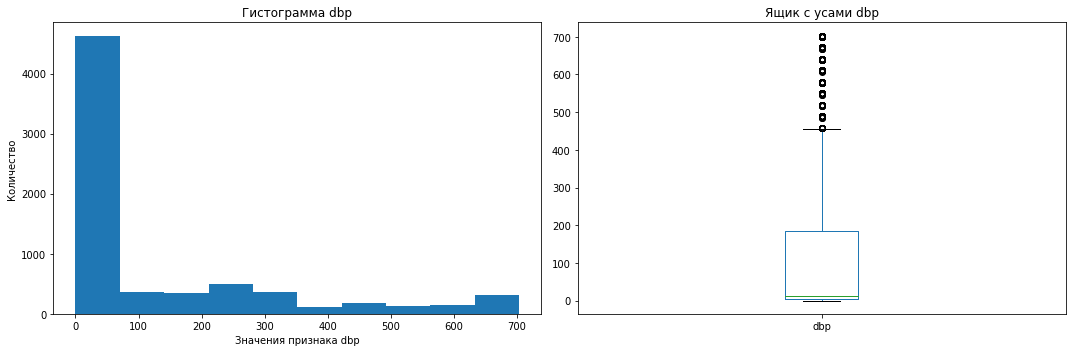

In [58]:
research_numeric_data(df_analisys, 'dbp')

Корреляция Phik: 0.24

      ---------------------------------------------------------------------------------------------------- 



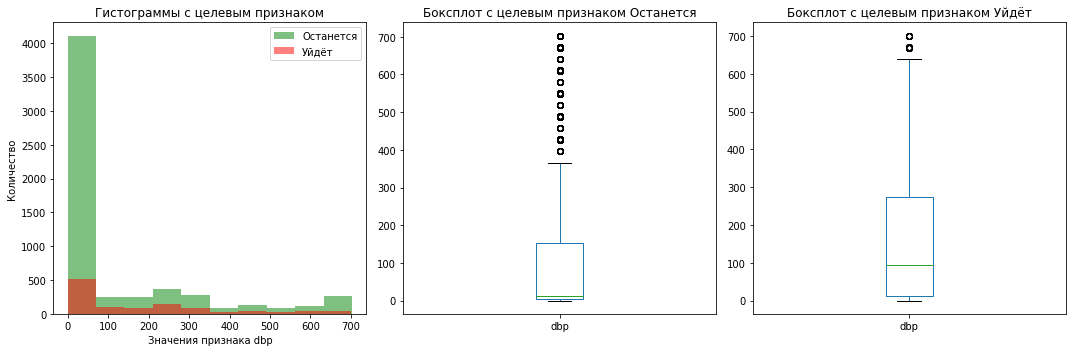

In [59]:
research_numeric_data_with_target(df_analisys, 'dbp', 'target_text')

В данном случае чаще как уходят так и остаются те, кто платит ежемесячно. В целом это понятно и так. Те, кто оплачивают услуги на год более склонны уйти чем те, кто оплачивает услуги сразу на два года. При этом примерно на 250 дне, те, кто оплатили услуги на год думают уйти больше чем те, кто на 200 дне. Вероятно в первое время возникают какие-то сложности и некоторые клиенты, что оплачивали услуги за год, уходят. Условно три месяца. Можно предположить, что на этом этапе возникает какая-то проблема из-за которой им перестаёт наравится сервис оператора.

### Вывод

* Определили целевую переменную;
* Преобразовали некоторые признаки и добавили новые;
* Построили матрицу корреляции и удалили признаки с мультиколлинеарностью и с низкой корреляцией к целевому признаку;
* Проанализировали отдельные признаки в связке с целевым;
* Чаще уходят клиенты с контрактами на месяц;
* Чаще уходят те, кто используют телефонию;
* Чаще уходят семьянины;
* Чаще уходят при общей сумме расходов более 2000 и являющихся нашими клиентами около 1000 дней;
* Чаще уходят клиенты с ежемесячными расходами более 80.

## Подготовка данных

### Разделение на выборки

Разделим данные на целевую переменную и фрейм с признаками.

In [60]:
features = df.drop('target', axis=1)
target = df['target']

Разобьем данные на обучающие и тренировочную выборки.

In [61]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

In [62]:
print('Обучающая выборка', features_train.shape[0], target_train.shape[0])
print('Тестовая выборка', features_test.shape[0], target_test.shape[0])

Обучающая выборка 5282 5282
Тестовая выборка 1761 1761


### Кодирование и масштабирование

Выделим наименования числовых признаков и категориальных. На одном из вебинаров на ютубе увидел `make_column_transformer`, попробую её в этом проекте, чтобы отдельно не выделять этапы. Пример есть на https://vc.ru/u/1389654-machine-learning/730865-19-samyh-elegantnyh-tryukov-sklearn-kotorye-ya-nashel-posle-3-let-ispolzovaniya

In [63]:
numeric = list(features.select_dtypes(include=['int64', 'float64']).columns)
categorical = list(features.select_dtypes(include='object').columns)

col_transformer_for_tree = make_column_transformer( 
    ( 
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        categorical
    ), 
    ( 
        StandardScaler(), 
        numeric
    ), 
    #verbose_feature_names_out=False 
)

col_transformer_for_lin = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        categorical
    ),
    (
        StandardScaler(),
        numeric
    ),
    remainder='passthrough',
    #verbose_feature_names_out=False
)

In [64]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   payment_method   7043 non-null   object 
 1   monthly_charges  7043 non-null   float64
 2   total_charges    7043 non-null   float64
 3   senior_citizen   7043 non-null   object 
 4   partner          7043 non-null   object 
 5   multiple_lines   7043 non-null   object 
 6   client_days      7043 non-null   int64  
 7   dbp              7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 753.2+ KB


In [65]:
print('Числовые столбцы:', numeric)
print('Категориальные столбцы:', categorical)

Числовые столбцы: ['monthly_charges', 'total_charges', 'client_days', 'dbp']
Категориальные столбцы: ['payment_method', 'senior_citizen', 'partner', 'multiple_lines']


In [66]:
col_transformer_for_lin

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['payment_method', 'senior_citizen', 'partner',
                                  'multiple_lines']),
                                ('standardscaler', StandardScaler(),
                                 ['monthly_charges', 'total_charges',
                                  'client_days', 'dbp'])])

In [67]:
col_transformer_for_tree

ColumnTransformer(transformers=[('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['payment_method', 'senior_citizen', 'partner',
                                  'multiple_lines']),
                                ('standardscaler', StandardScaler(),
                                 ['monthly_charges', 'total_charges',
                                  'client_days', 'dbp'])])

Разделили признаки по их типам, отделив числовые от категориальных. При помощи `make_column_transformer` создали предварительно трансформеры для линейных моделей и деревьев, вывели отдельно для визуального удобства и лучшего понимания работы метода.

## Обучение моделей машинного обучения

Перед обучением моделей разберемся с метриками. В проекте будем использовать `ROC_AUC`, потому что данную метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другим. Кроме того полученная метрика должна быть выше 0.85.

В качестве моделей для задачи предварительно выберем:
* LogisticRegression;
* DecisionTreeClassifier;
* RandomForestClassifier;
* CatBoostClassifier

### LogisticRegression

Зададим словарь для перебора параметров в `GridSearchCV` или `RandomizedSearchCV`. Обучим модель и посмотрим на метрику.

In [68]:
params_lr = {'logisticregression__C': np.linspace(0.01, 100, 1000),
             'logisticregression__penalty': ['l2'],
             'logisticregression__solver': ['liblinear', 'newton-cg', 'saga'],
             'logisticregression__class_weight': ['balanced'],
         }

In [69]:
%%time
model_lr = LogisticRegression(random_state=RANDOM_STATE)
pipeline_lr = make_pipeline(col_transformer_for_lin, model_lr)

lr_rscv = RandomizedSearchCV(
    pipeline_lr,
    params_lr,
    cv=3,
    random_state=RANDOM_STATE,
    scoring='roc_auc'
)
lr_rscv.fit(features_train, target_train)

print('Лучшее значение метрики ROC_AUC:', round(lr_rscv.best_score_, 2))

Лучшее значение метрики ROC_AUC: 0.73
CPU times: user 4.11 s, sys: 3.73 s, total: 7.84 s
Wall time: 7.86 s


In [70]:
print('Лучшие гиперпараметры модели:')
lr_rscv.best_params_

Лучшие гиперпараметры модели:


{'logisticregression__solver': 'saga',
 'logisticregression__penalty': 'l2',
 'logisticregression__class_weight': 'balanced',
 'logisticregression__C': 5.915315315315315}

В данном случае используем рандомный подход к перебору гиперпараметров. За 5 секунд он подбирает их так, что получаем метрику в 0.73, что меньше требуемых заказчиком, но без рандома он перебирает параметры порядка 7 минут и получает такую метрику.

### DecisionTreeClassifier

In [71]:
params_dtc = {'decisiontreeclassifier__max_depth' : [1, 5, 10, 15, 30],
              'decisiontreeclassifier__min_samples_split' : [2, 4],
              'decisiontreeclassifier__min_samples_leaf' : [1, 2, 3]
         }

In [72]:
%%time
model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipeline_dtc = make_pipeline(col_transformer_for_tree, model_dtc)

dtc_gscv = GridSearchCV(
    pipeline_dtc,
    params_dtc,
    cv=3,
    scoring='roc_auc'
)
dtc_gscv.fit(features_train, target_train)

print('Лучшее значение метрики ROC_AUC:', round(dtc_gscv.best_score_, 2))

Лучшее значение метрики ROC_AUC: 0.79
CPU times: user 2.45 s, sys: 7.39 ms, total: 2.45 s
Wall time: 2.47 s


In [73]:
print('Лучшие гиперпараметры модели:')
dtc_gscv.best_params_

Лучшие гиперпараметры модели:


{'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 2,
 'decisiontreeclassifier__min_samples_split': 2}

Дерево решений уже справляется лучше логистической регрессии, но величина метрики всё еще ниже требуемой.

### RandomForestClassifier

In [74]:
params_rfc = [{'randomforestclassifier__n_estimators' : [50, 200, 400],
               'randomforestclassifier__max_depth' : [15, 30, 60],
               'randomforestclassifier__min_samples_split' : [2, 4, 6],
               'randomforestclassifier__class_weight' : ['balanced']
         }]

In [75]:
%%time
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)
pipeline_rfc = make_pipeline(col_transformer_for_tree, model_rfc)

rfc_gscv = GridSearchCV(
    pipeline_rfc,
    params_rfc,
    cv=3,
    scoring='roc_auc'
)
rfc_gscv.fit(features_train, target_train)

print('Лучшее значение метрики ROC_AUC:', round(rfc_gscv.best_score_, 2))

Лучшее значение метрики ROC_AUC: 0.83
CPU times: user 1min 9s, sys: 344 ms, total: 1min 9s
Wall time: 1min 10s


In [76]:
print('Лучшие гиперпараметры модели:')
rfc_gscv.best_params_

Лучшие гиперпараметры модели:


{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_split': 6,
 'randomforestclassifier__n_estimators': 400}

Случайный лес справляется еще лучше и метрика качества очень близка к тербуемой, но всё еще недостаточна.

### CatBoostClassifier

In [77]:
params_cbc = [{'catboostclassifier__learning_rate': [0.01, 0.25, 0.5, 1],
               'catboostclassifier__depth': np.arange(2, 11),
               'catboostclassifier__iterations': [500, 1000, 2000]
         }]

In [78]:
%%time
model_cbc = CatBoostClassifier(
    logging_level='Silent',
    loss_function='Logloss',
    random_state=RANDOM_STATE)
pipeline_cbc = make_pipeline(col_transformer_for_tree, model_cbc)

cbc_rscv = RandomizedSearchCV(
    pipeline_cbc,
    params_cbc,
    cv=3,
    random_state=RANDOM_STATE,
    scoring='roc_auc'
)
cbc_rscv.fit(features_train, target_train)

print('Лучшее значение метрики ROC_AUC:', round(cbc_rscv.best_score_, 2))

Лучшее значение метрики ROC_AUC: 0.91
CPU times: user 1min 42s, sys: 2.7 s, total: 1min 45s
Wall time: 2min 8s



<div class="alert alert-block alert-warning"; style="border-left: 6px solid orange">
<b>Рекомендация ⚠️</b>
       
CatBoost может работать на "сырых" данных
    
</div>


In [79]:
print('Лучшие гиперпараметры модели:')
cbc_rscv.best_params_

Лучшие гиперпараметры модели:


{'catboostclassifier__learning_rate': 0.5,
 'catboostclassifier__iterations': 500,
 'catboostclassifier__depth': 2}

Для удобства выведем показатели моделей во фрейм.

In [80]:
pd.DataFrame([
    ['LogisticRegression', round(lr_rscv.best_score_, 2)],
    ['DecisionTreeClassifier', round(dtc_gscv.best_score_, 2)],
    ['RandomForestClassifier', round(rfc_gscv.best_score_, 2)],
    ['CatBoostClassifier', round(cbc_rscv.best_score_, 2)]],
    columns=['Model', 'ROC_AUC']
)

,Model,ROC_AUC
0,LogisticRegression,0.73
1,DecisionTreeClassifier,0.79
2,RandomForestClassifier,0.83
3,CatBoostClassifier,0.91


Как видно по значению выбранной метрики, успешно с задачей справился бустинг. Поэтому лучшей моделью выбираем `CatBoostClassifier`, с гиперпараметрами `{'catboostclassifier__learning_rate': 0.25, 'catboostclassifier__iterations': 2000, 'catboostclassifier__depth': 2}`, выдающий метрику в 0.91.

## Выбор лучшей модели

### Предсказание на тестовых данных

Лучшей моделью выбираем CatBoostClassifier, с гиперпараметрами {'catboostclassifier__learning_rate': 0.25, 'catboostclassifier__iterations': 2000, 'catboostclassifier__depth': 2}, выдающий метрику в 0.91, что выполняет требования заказчика более 0.85.    
    
Инициализируем лучшую модель и предскажем уход клиентов на тестовых данных.

In [81]:
model = cbc_rscv.best_estimator_

Оценим метрику качества на тестовых данных:

In [82]:
y_pred_proba = model.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, y_pred_proba)
print('ROC_AUC на тестовом наборе данных:', round(auc_roc, 2))

ROC_AUC на тестовом наборе данных: 0.95


### ROC-кривая

На тестовом наборе данных метрика даже лучше чем на обучающем. Построим ROC кривую.

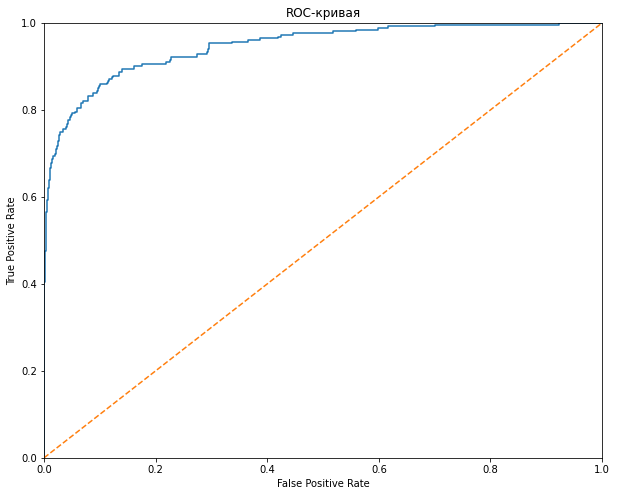

In [83]:
predicted_probalities = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

ROC кривая имеет под собой довольно большую площадь, что говори нам о том, что модель достаточно хорошо предсказывает намерения пользователя расторгнуть контракт и отказаться от услуг.

### Матрица ошибок

Визуализируем матрицу ошибок.

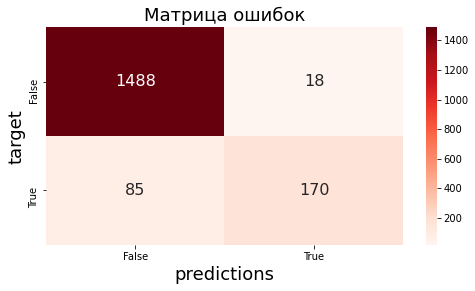

In [84]:
cm_cbc = confusion_matrix(target_test, model.predict(features_test))
cm_cbc_data = pd.DataFrame(cm_cbc,
                           index=['False', 'True'],
                           columns=['False', 'True'])

plt.figure(figsize=(8, 4))
sns.heatmap(cm_cbc, xticklabels=cm_cbc_data.columns, yticklabels=cm_cbc_data.index, annot=True, fmt='g', cmap="Reds", annot_kws={"size": 16})
plt.title("Матрица ошибок", size=18)
plt.xlabel('predictions', size=18)
plt.ylabel('target', size=18);

Больше всего значений находится как мы видим в TP, то есть модель верно определила некоторое количество пользователей, которые не ушли от оператора.

### Важность признаков

In [85]:
table = pd.DataFrame({
    'name': model[:-1].get_feature_names_out(),
    'score': model.named_steps['catboostclassifier'].get_feature_importance()})
table.sort_values(by='score', ascending=False)

,name,score
6,standardscaler__client_days,49.997731
7,standardscaler__dbp,24.966691
4,standardscaler__monthly_charges,10.874101
5,standardscaler__total_charges,8.791999
2,ordinalencoder__partner,1.822134
3,ordinalencoder__multiple_lines,1.635743
0,ordinalencoder__payment_method,1.358762
1,ordinalencoder__senior_citizen,0.552839


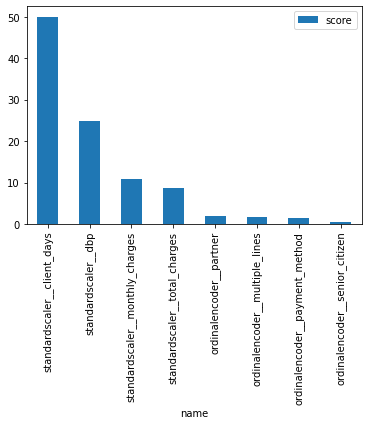

In [86]:
table.sort_values(by='score', ascending=False).plot.bar(x='name', y='score');

Самыми важными признаками стали:
* client_days - количество дней, которые клиент пользуется услугами;
* dbp - дней до оплаты за следующий период;
* total_charges - общее количество расходов;
* monthly_charges - ежемесячное количество расходов.

## Общий вывод и рекомендации заказчику

В рамках выполнения задачи нам нужно было предсказать уйдет ли клиент от заказчика или нет. Были проанализированы исходные фреймы и выполнены пункты согласно плану. Я не стал исследовать данные до объединения и выполнять по сути двойной исследовательский анализ, поскольку лучшую зависимостьмежду признаками видно на уже объединенном фрейме. В остальном работа выполнена согласно плану.    

Возникали сложности при определении целевого признака `end_date` и дополнительных признаков, а так же при обучении моделей. Целевым признаком выступил признак с датой окончания договора. По нему мы смогли понять, кто уже ушел и кто только заключил договор. Дополнительно были созданы два признака: `client_days`(сколько дней клиент пользовался услугами) и `dbp`(days before payment - дней до оплаты за следующий период). Эти два признака могли оказать значительное влияние на то расторгнет ли клиент договор или нет, что в последствии и подтвердилось важностью этих двух созданных признаков.   

Можно выделить ключевые этапы работы:
* Загрузка и предобработка данных - на этом этапе мы загрузили данные из файлов, проанализировали данные, выполнили предварительную предобработку данных;
* Затем объединили данные в один фрейм - заполнили пропуски, которые появились поскольку некоторые клиенты пользуются только телефоном, но не пользуются интернетом и наоборот;
* После этого провели исследовательский анализ и предобработку уже объединенного фрейма - выделли целевой признак, добавили дополнительный, построили матрицу корреляции и скоратили общее кол-во признаков до 9, считая именно их ключевыми для обучения;
    Основными предположениями и ввыводами на основе исследовательского анализа стали следующие умозаключения:
    1. Чаще уходят клиенты с контрактами на месяц;
    2. Чаще уходят те, кто используют телефонию;
    3. Чаще уходят семьянины;
    4. Чаще уходят при общей сумме расходов более 2000 и являющихся нашими клиентами около 1000 дней;
    5. Чаще уходят клиенты с ежемесячными расходами более 80.
* На этапе подготовки данных выделили целевой признак и важные признаки для модели:
    * `payment_method` - тип платежа. Преобработка не потребовалась, данный признак был достаточно чист;
    * `monthly_charges` - расходы за месяц. Преобработка не потребовалась, данный признак был достаточно чист;
    * `total_charges` - общие расходы абонента. В данном признаке присутствовали пробелы, поэтому было необходимо их заменить на ноль, как допущение того, что это новые абоненты и пока они не вносили оплату за использование услуг;
    * `senior_citizen` - является ли абонент пенсионером. Изначально содержал данные булевой логики '0' и '1', что могло вносить некоторую путаницу и мешать обучению модели. Были заменены на 'yes', 'no';
    * `partner` - есть ли у абонента супруг или супруга. Преобработка не потребовалась, данный признак был достаточно чист;
    * `multiple_lines` - подключение телефона к нескольким линиям одновременно. При объединении фреймой в данных появились пропуски, которые были заполнены заглушкой. Причина пропусков в том, что некоторые абоненты не пользуются интернетом, а только телефонией;
    * `client_days` - сколько дней клиент пользовался услугами. Создали этот признак исходя из того, что длительность пользования услуги будет являться важным показателем при обучении модели и выдачи прогноза, но и так же позволит оператору оценить насколько долго он удерживает клиента, пока тот не решит отказаться от услуг;
    * `dbp` - дней до оплаты за следующий период. Создали этот признак, чтобы увидеть в рамках какой модели оплаты клиентов больше и как себя ведут клиенты при разных способах оплаты. Будут ли эти способы влиять на то, какие пользователи чаще остальных уйдут от оператора.    
    Затем разделили данные на обучающую и тестовую выборки;
* Выбрали ключевую метрику проекта `ROC_AUC` потому, что данную метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другим. Кроме того полученная метрика должна быть выше 0.85;
* Обучили несколько моделей при помощи кросс-валидации: `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier`, `CatBoostClassifier`;

Лучшей моделью по итогу оказалась модель `CatBoostClassifier` с гиперпараметрами `learning_rate`=0.5, `iterations`= 500, `depth`= 2 с получившейся на вызоде метрикой `ROC_AUC` = 0,91 для обучающей выборки, и 0,95 для тестовой выборки. 

Рекомендации для бизнеса:
* Сосредоточить внимание на ценовой политике, очень большой разрос расходов разных клиентов. В итоге одни платят занчительно больше других;
* Продумать семейные тарифы, некоторые семейные клиенты на фоне роста тарифов отказываются от услуг;
* Ориентироваться на средний расход клиента не более 80 в месяц;
* Если необходимо удержать клиентов с телефонией, то следует продумать какую-либо акции или выяснить причины, почему некоторые клиенты отказываются от этих услуг.